<a href="https://colab.research.google.com/github/KelestZ/HighResImg_Gen/blob/master/NDBLP_gvgan_cp_from_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')
import os    
os.chdir("/content/gdrive/My Drive/gcn-data/")
!ls


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
'graph_stat (1).py'   PGG_dblp		     '__pycache__ (1)'	 sub.node.dat
 graph_stat.py	      PGG_dblp_version2.zip   sub.label.dat
 NDBLP		      __pycache__	      sub.link.dat


In [0]:
!pip3 install python-igraph
!pip3 install powerlaw

In [0]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import math
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import numpy as np
from sklearn.manifold import SpectralEmbedding
import torch.optim as optim
import warnings
import scipy.sparse as sp
from pprint import pprint
from graph_stat import *
warnings.filterwarnings("ignore")


In [0]:
a = np.array([
    [0, 1, 0],
    [1, 0, 0],
    [0, 0, 0]
])
compute_graph_statistics(a)

Values less than or equal to 0 in data. Throwing out 0 or negative values


{'LCC': 2,
 'claw_count': 0.0,
 'cpl': 1.0,
 'd': 0.6666666666666666,
 'd_max': 1,
 'd_min': 0,
 'edge_num': 1,
 'gini': -0.33333333333333326,
 'n_components': 2,
 'node_num': 3,
 'power_law_exp': inf,
 'rel_edge_distr_entropy': 0.6308387341996874,
 'square_count': 0,
 'triangle_count': 0,
 'wedge_count': 0.0}

In [0]:
import torch
a = torch.Tensor([1]).cuda()
print(a)
torch.cuda.is_available()

tensor([1.], device='cuda:0')


True

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import copy

# def show_graph(adj, bd, thresh=.5):
#     if not isinstance(adj, np.ndarray):
#         adj_ = adj.data.cpu().numpy()
#     else:
#         adj_ = copy.deepcopy(adj)
#     # adj_ = adj_ / np.max(adj_)
#     rows, cols = np.where(adj_ > thresh)
#     if rows.size == 0:
#         print('empty graph to print')
#         return
#     edges = zip(rows.tolist(), cols.tolist())
#     gr = nx.Graph()
#     gr.add_edges_from(edges)
#     nx.draw(gr, node_size=30)
#     plt.show()
#     a = nx.to_numpy_array(gr)
#     d = compute_graph_statistics(a)
#     pprint(d)
#     diff_d = {}
    

#     for k in list(d.keys()):
#         diff_d[k] = abs(d[k] - bd[k])
#     print((diff_d.keys()))
#     print((diff_d.values()))
#     return diff_d
    

def show_graph(adj, base_adj=None, remove_isolated=False):
    if not isinstance(adj, np.ndarray):
        adj_ = adj.data.cpu().numpy()
    else:
        adj_ = copy.deepcopy(adj)
    
    adj_ -= np.diag(np.diag(adj_))
   
    gr = nx.from_numpy_array(adj_)
    assert((adj_ == adj_.T).all())
    if remove_isolated:
        gr.remove_nodes_from(list(nx.isolates(gr)))
    nx.draw(gr, node_size=10)
    plt.title('gen')
    plt.show()
    d = compute_graph_statistics(adj_)
    pprint(d)
    
    if base_adj is not None:
        base_gr = nx.from_numpy_array(base_adj)
        nx.draw(base_gr, node_size=10)
        plt.title('base')
        plt.show()
        bd = compute_graph_statistics(base_adj)
        diff_d = {}
        for k in list(d.keys()):
            diff_d[k] = round(abs(d[k] - bd[k]), 4)
        print(diff_d.keys())
        print(diff_d.values())


# def show_graph(adj, thresh=.5):
#     if not isinstance(adj, np.ndarray):
#         adj_ = adj.data.cpu().numpy()
#     else:
#         adj_ = copy.deepcopy(adj)
#     # adj_ = adj_ / np.max(adj_)
#     rows, cols = np.where(adj_ > thresh)
#     if rows.size == 0:
#         print('empty graph to print')
#         return
#     edges = zip(rows.tolist(), cols.tolist())
#     gr = nx.Graph()
#     gr.add_edges_from(edges)
#     nx.draw(gr, node_size=30)
#     plt.show()
#     a = nx.to_numpy_array(gr)
#     pprint(compute_graph_statistics(a))
    
        
def make_symmetric(m):
    m_ = torch.transpose(m)
    w = torch.max(m_, m_.T)
    return w


def make_adj(x, n):
    res = torch.zeros(n, n).cuda()
    i = 0
    for r in range(1, n):
        for c in range(r, n):
            res[r, c] = x[i]
            res[c, r] = res[r, c]
            i += 1
    return res


def cat_attr(x, attr_vec):
    if attr_vec is None:
        return x
    attr_mat = attr_vec.repeat(x.size()[0], 1)
    x = torch.cat([x, attr_mat], dim=1)
    return x


def get_spectral_embedding(adj, d):
    """
    Given adj is N*N, return its feature mat N*D, D is fixed in model
    :param adj:
    :return:
    """
    
    adj_ = adj.data.cpu().numpy()
    emb = SpectralEmbedding(n_components=d)
    res = emb.fit_transform(adj_)
    x = torch.from_numpy(res).float().cuda()
    '''
    x=torch.eye(adj.size()[0]).cuda()
    '''
    return x

'''
def normalize(mx):
    """Row-normalize sparse matrix"""
    mx = mx.data.cpu().numpy()
    mx += sp.eye(mx.shape[0])
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return torch.from_numpy(mx).float().cuda()
'''
def normalize(adj):
    adj = adj.data.cpu().numpy()
    adj_ = adj + np.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = np.diag(np.power(rowsum, -0.5).flatten())
    degree_mat_sqrt = np.diag(np.power(rowsum, 0.5).flatten())
    adj_normalized = degree_mat_inv_sqrt.dot(adj_).dot(degree_mat_sqrt)
    return torch.from_numpy(adj_normalized).float().cuda()

def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    return sparse_to_tuple(adj_normalized)


In [0]:
# from pprint import pprint
# from collections import defaultdict

# NODE_FILE = 'node.dat'
# LINK_FILE = 'link.dat'
# LABEL_FILE = 'label.dat'
# DATA_DIR = 'data'
# mat_names = []
# adj_mats = []
# id_maps = []

# cnt = 0
# for folder in os.listdir(DATA_DIR):
#     cnt += 1
#     if cnt > 100:
#         break
#     mat_names.append(folder)
#     id_to_item = {}
#     with open(os.path.join(DATA_DIR, folder, NODE_FILE), 'r') as f:
#         for i, line in enumerate(f):
#             cells = line.split('\t')
#             id_to_item[i] = cells[0]

#     all_items = set(id_to_item.values())
#     all_ids = set(id_to_item.keys())
        
#     links = defaultdict(set)
#     with open(os.path.join(DATA_DIR, folder, LINK_FILE), 'r') as f:
#         for line in f:
#             cells = line.rstrip('\n').split('\t')
#             from_id = int(cells[0])
#             to_id = int(cells[1])
#             if from_id in all_ids and to_id in all_ids:
#                 links[from_id].add(to_id)
    
#     N = len(all_ids)
#     adj = np.zeros((N, N))
#     for from_id in range(N):
#         for to_id in links[i]:
#             adj[from_id, to_id] = 1
#             adj[to_id, from_id] = 1
#     id_map = [id_to_item[i] for i in range(N)]
    
#     adj_mats.append(adj)
#     id_maps.append(id_map)
    

# t_adj_mats = [torch.from_numpy(m).float() for m in adj_mats]
# torch.manual_seed(0)
# t_attr_vecs = torch.randn(len(t_adj_mats), 8)
    

# for i in range(3):
#     print('No:', i, mat_names[i])
#     print('Adj Mat', adj_mats[i].shape)
#     print(adj_mats[i])
#     show_graph(adj_mats[i])
#     print('# of nodes', len(id_maps[i]))
#     print('# of links', np.count_nonzero(adj_mats[i]) // 2)
#     print('Item names', id_maps[i])
#     print('Attr vec', t_attr_vecs[i, :])


In [0]:
# from pprint import pprint
# from collections import defaultdict

# NODE_FILE = 'sub.node.dat'
# LINK_FILE = 'sub.link.dat'
# LABEL_FILE = 'sub.label.dat'

# id_to_author = {}
# id_to_fv = {}
# with open(NODE_FILE, 'r') as f:
#     for i, line in enumerate(f):
#         cells = line.split('\t')
#         if cells[1] == '1':
#             id_to_author[i] = cells[0]
#             id_to_fv[i] = np.asarray([float(a) for a in cells[-1].split(',')])
# all_authors = set(id_to_author.values())
# all_ids = set(id_to_author.keys())

# sg_to_ids = defaultdict(list)
# author_to_id = {v: k for k, v in id_to_author.items()}
# with open(LABEL_FILE, 'r') as f:
#     for line in f:
#         cells = line.rstrip('\n').split('\t')
#         if cells[1] == '1' and cells[0] in all_authors:
#             sg_to_ids[int(cells[2])].append(author_to_id[cells[0]])
# for k, v in sg_to_ids.items():
#     v.sort()
    
# links = defaultdict(set)
# with open(LINK_FILE, 'r') as f:
#     for line in f:
#         cells = line.rstrip('\n').split('\t')
#         from_id = int(cells[0])
#         to_id = int(cells[1])
#         if from_id in all_ids and to_id in all_ids:
#             links[from_id].add(to_id)
# print('total links', sum(len(s) for s in links.values()))

# adj_mats = []
# id_maps = []
# author_maps = []
# feature_mats = []
# M = len(id_to_fv[15055])
# for sg, ids in sg_to_ids.items():
#     N = len(ids)
#     cur_ids = set(ids)
#     adj_mat = np.zeros((N, N))
#     feature_mat = np.zeros((N, M))
#     row_map = {id: i for i, id in enumerate(ids)}
#     for id in ids:
#         for to_id in links[id]:
#             if to_id not in cur_ids:
#                 continue
#             r = row_map[id]
#             c = row_map[to_id]
#             adj_mat[r, c] = 1
#             adj_mat[c, r] = 1
#             feature_mat[r, :] = id_to_fv[id]
#     adj_mats.append(adj_mat)
#     id_maps.append(ids)
#     author_maps.append([id_to_author[id] for id in ids])
#     feature_mats.append(feature_mat)

# for i in range(len(adj_mats)):
#     print('Sub Group:', i)
#     print('Adj Mat', adj_mats[i].shape)
#     print(adj_mats[i])
#     print('Feature Mat', feature_mats[i].shape)
#     print(feature_mats[i])
#     print('# of nodes', len(id_maps[i]))
#     print('# of links', np.count_nonzero(adj_mats[i]) // 2)
#     print('Author IDs', id_maps[i])
#     print('Author Names', author_maps[i])



In [0]:
def keep_topk_conns(adj, k=3):
    g = nx.from_numpy_array(adj)
    to_removes = [cp for cp in sorted(nx.connected_components(g), key=len)][:-k]
    for cp in to_removes:
        g.remove_nodes_from(cp)
    adj = nx.to_numpy_array(g)
    return adj


def remove_small_conns(adj, keep_min_conn=4):
    g = nx.from_numpy_array(adj)
    for cp in list(nx.algorithms.components.connected_components(g)):
        if len(cp) < keep_min_conn:
            g.remove_nodes_from(cp)
    adj = nx.to_numpy_array(g)
    return adj

In [0]:
# script for loading NWE dblp
# folder structure
# - this.ipynb
# - $DATA_DIR - *.txt

from pprint import pprint
from collections import defaultdict
import os
import numpy as np

NODE_FILE = 'node.dat'
LINK_FILE = 'link.dat'
LABEL_FILE = 'label.dat'
ATTR_FILE = 'attribute.dat'
DATA_DIR = 'PGG_dblp'
mat_names = []  # e.g. GSE_2304
adj_mats = []  # essential data, type: list(np.ndarray)
attr_vecs = [] # essential data, type: list(np.ndarray)
id_maps = []  # map index to gene name if you need

for f in os.listdir(DATA_DIR):
    if not f.startswith(('nodes', 'links', 'attrs')):
        continue
    else:
        mat_names.append('_'.join(f.split('.')[0].split('_')[1:]))
mat_names = sorted([it for it in set(mat_names)])
print(mat_names)
print('Test length', len(mat_names))
for mat_name in mat_names:
    node_file = 'nodes_' + mat_name + '.txt'
    link_file = 'links_' + mat_name + '.txt'
    attr_file  = 'attrs_' + mat_name + '.txt'
    node_file_path = os.path.join(DATA_DIR, node_file)
    link_file_path = os.path.join(DATA_DIR, link_file)
    attr_file_path = os.path.join(DATA_DIR, attr_file)
    
    id_to_item = {}
    with open(node_file_path, 'r') as f:
        for i, line in enumerate(f):
            author = line.rstrip('\n')
            id_to_item[i] = author
    all_ids = set(id_to_item.keys())
    
    with open(attr_file_path, 'r') as f:
        attr_vec = np.loadtxt(f).T.flatten()
        attr_vecs.append(attr_vec)
    
    links = defaultdict(set)
    with open(link_file_path, 'r') as f:
        for line in f:
            cells = line.rstrip('\n').split(',')
            from_id = int(cells[0])
            to_id = int(cells[1])
            if from_id in all_ids and to_id in all_ids:
                links[from_id].add(to_id)
    
    N = len(all_ids)
    adj = np.zeros((N, N))
    for from_id in range(N):
        for to_id in links[from_id]:
            adj[from_id, to_id] = 1
            adj[to_id, from_id] = 1
            
    adj -= np.diag(np.diag(adj))
    id_map = [id_to_item[i] for i in range(N)]
    
    
    # Remove small component
    # adj = remove_small_conns(adj, keep_min_conn=4)
    
    # Keep large component 
    adj = keep_topk_conns(adj, k=1)
    adj_mats.append(adj)
    id_maps.append(id_map)
    
    if int(np.sum(adj)) == 0:
        adj_mats.pop(-1)
        id_maps.pop(-1)
        mat_names.pop(-1)
        attr_vecs.pop(-1)
                
        
        
# print some samples
for i in range(5):
    print('No:', i, mat_names[i])
    print('Adj Mat', adj_mats[i].shape)
    print(adj_mats[i])
    print('# of nodes', len(id_maps[i]))
    print('# of links', np.count_nonzero(adj_mats[i]) // 2)
    print('Atrribute vector', attr_vecs[i].shape)
    print(attr_vecs[i])
    print('Item names', id_maps[i])
    print('Components')
    print(list(nx.algorithms.components.connected_components(nx.from_numpy_array(adj_mats[i]))))
    
train_adj_mats = adj_mats[:int(len(adj_mats) * .8)]
test_adj_mats = adj_mats[int(len(adj_mats) * .8):]
train_attr_vecs = attr_vecs[:int(len(attr_vecs) * .8)]
test_attr_vecs = attr_vecs[int(len(attr_vecs) * .8):]

['ckim_00-09_0-10', 'ckim_00-09_10-30', 'ckim_00-09_30+', 'ckim_10-19_0-10', 'ckim_10-19_10-30', 'ckim_10-19_30+', 'ckim_90-99_0-10', 'ckim_90-99_10-30', 'ckim_90-99_30+', 'icdm_00-09_0-10', 'icdm_00-09_10-30', 'icdm_00-09_30+', 'icdm_10-19_0-10', 'icdm_10-19_10-30', 'icdm_10-19_30+', 'icdm_90-99_0-10', 'icdm_90-99_10-30', 'icdm_90-99_30+', 'icml_00-09_0-10', 'icml_00-09_10-30', 'icml_00-09_30+', 'icml_10-19_0-10', 'icml_10-19_10-30', 'icml_10-19_30+', 'icml_90-99_0-10', 'icml_90-99_10-30', 'icml_90-99_30+', 'kdd_00-09_0-10', 'kdd_00-09_10-30', 'kdd_00-09_30+', 'kdd_10-19_0-10', 'kdd_10-19_10-30', 'kdd_10-19_30+', 'kdd_90-99_0-10', 'kdd_90-99_10-30', 'kdd_90-99_30+', 'nips_00-09_0-10', 'nips_00-09_10-30', 'nips_00-09_30+', 'nips_10-19_0-10', 'nips_10-19_10-30', 'nips_10-19_30+', 'nips_90-99_0-10', 'nips_90-99_10-30', 'nips_90-99_30+', 'sigir_00-09_0-10', 'sigir_00-09_10-30', 'sigir_00-09_30+', 'sigir_10-19_0-10', 'sigir_10-19_10-30', 'sigir_10-19_30+', 'sigir_90-99_0-10', 'sigir_90-99_

In [0]:


def show_graph(adj, base_adj=None, remove_isolated=True):
    if not isinstance(adj, np.ndarray):
        adj_ = adj.data.cpu().numpy()
    else:
        adj_ = copy.deepcopy(adj)
    
    adj_ -= np.diag(np.diag(adj_))
   
    gr = nx.from_numpy_array(adj_)
    assert((adj_ == adj_.T).all())
    if remove_isolated:
        gr.remove_nodes_from(list(nx.isolates(gr)))
    nx.draw(gr, node_size=10)
    plt.title('gen')
    plt.show()
    
    d = compute_graph_statistics(adj_)
    pprint(d)
    
    if base_adj is not None:
        base_gr = nx.from_numpy_array(base_adj)
        nx.draw(base_gr, node_size=10)
        plt.title('base')
        plt.show()
        bd = compute_graph_statistics(base_adj)
        diff_d = {}
        for k in list(d.keys()):
            diff_d[k] = round(abs(d[k] - bd[k]), 4)
        print(diff_d.keys())
        print(diff_d.values())

 

52
14
66


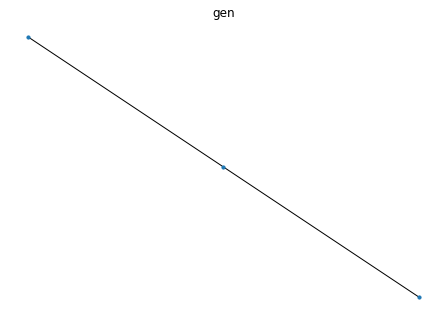

{'LCC': 3,
 'claw_count': 0.0,
 'cpl': 1.3333333333333333,
 'd': 1.3333333333333333,
 'd_max': 2.0,
 'd_min': 1.0,
 'edge_num': 2,
 'gini': -0.4999999999999999,
 'n_components': 1,
 'node_num': 3,
 'power_law_exp': 5.328085122666891,
 'rel_edge_distr_entropy': 0.946326365259516,
 'square_count': 0,
 'triangle_count': 0,
 'wedge_count': 1.0}


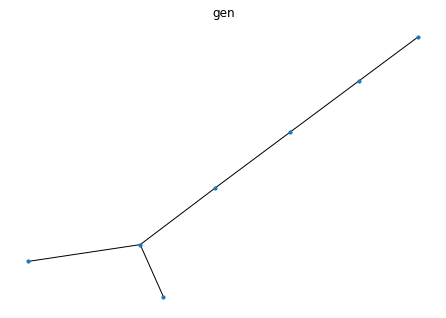

{'LCC': 7,
 'claw_count': 1.0,
 'cpl': 2.4761904761904763,
 'd': 1.7142857142857142,
 'd_max': 3.0,
 'd_min': 1.0,
 'edge_num': 6,
 'gini': -0.0714285714285714,
 'n_components': 1,
 'node_num': 7,
 'power_law_exp': 3.2026058631088743,
 'rel_edge_distr_entropy': 0.9577120798337921,
 'square_count': 0,
 'triangle_count': 0,
 'wedge_count': 6.0}


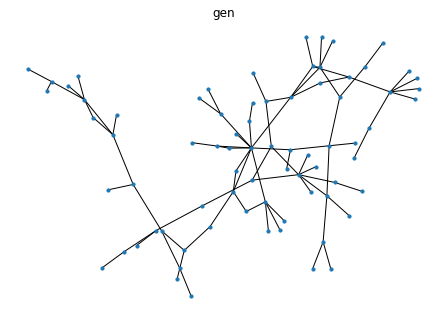

{'LCC': 76,
 'claw_count': 249.0,
 'cpl': 6.415087719298246,
 'd': 2.210526315789474,
 'd_max': 10.0,
 'd_min': 1.0,
 'edge_num': 84,
 'gini': 0.33286340852130336,
 'n_components': 1,
 'node_num': 76,
 'power_law_exp': 2.7351216464482864,
 'rel_edge_distr_entropy': 0.9474673548740912,
 'square_count': 0,
 'triangle_count': 5,
 'wedge_count': 206.0}


In [0]:
print(len(train_adj_mats))
print(len(test_adj_mats))
print(len(adj_mats))

for i in range(3):
    a = train_adj_mats[i]
    show_graph(a) # There should be a bds[i]
    

In [0]:
# t_adj_mats = [torch.from_numpy(m).float() for m in adj_mats]
# t_attr_vecs = torch.eye(len(adj_mats))
# bds = [compute_graph_statistics(adj_mats[i]) for i in range(len(t_adj_mats))]

# for i in range(len(t_adj_mats)):
#     print(t_attr_vecs[i])
#     a = t_adj_mats[i]
#     print('i:', i, 'bds',bds[i])
    
#     #show_graph(a,bds[i])
#     show_graph(a)

In [0]:
class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

In [0]:
class Encoder(nn.Module):
    def __init__(self, av_size, d_size, gc_size, z_size, rep_size):
        """

        :param av_size: D_A
        :param d_size: D_X
        :param gc_size: D'
        :param z_size: z
        """
        super(Encoder, self).__init__()
        # input parameters
        self.z_size = z_size
        self.attr_vec = None
        self.gc_size = gc_size
        self.z_size = z_size
        self.d_size = d_size
        self.av_size = av_size
        self.rep_size = rep_size
        
        self.gc = GraphConvolution(d_size + av_size, gc_size)
        self.gc_mu = GraphConvolution(gc_size, z_size)
        self.gc_logvar = GraphConvolution(gc_size, z_size)
        
        # self.mean = nn.Sequential( nn.Linear(gc_size, z_size))
        # self.logvar = nn.Sequential(nn.Linear(gc_size, z_size)) 
        
        self.mean = nn.Sequential(nn.Linear(self.gc_size, int(self.gc_size/4)), 
                                  nn.BatchNorm1d(int(self.gc_size/4)), 
                                  nn.ReLU(), 
                                  nn.Linear(int(self.gc_size/4), self.z_size))
        
        self.logvar = nn.Sequential(nn.Linear(self.gc_size, int(self.gc_size/4)), 
                                    nn.BatchNorm1d(int(self.gc_size/4)), 
                                    nn.ReLU(), 
                                    nn.Linear(int(self.gc_size/4), self.z_size))
    def set_attr_vec(self, attr_vec):
        self.attr_vec = attr_vec

    def forward(self, adj):
        # print('adj size',adj.size())
        x = get_spectral_embedding(adj, d=self.d_size)
        # print('Encoder, before mean logvar', x.size())
        
        adj = normalize(adj)
        x = cat_attr(x, self.attr_vec)
        # print('Before gc', 'x,size', x.size(),'att size',self.attr_vec.size()  , 'adj.size', adj.size())
        x = F.relu(self.gc(x, adj))
        x = F.dropout(x, p=0.5)
        
        # print('After gc')
        #z_mean = self.gc_mu(x, adj)
        #z_logvar = self.gc_logvar(x, adj)
        
        # create graph embedding N*D' -> 1*D'
        # x = x.sum(0)
        z_mean = self.mean(x)
        z_logvar = self.logvar(x)
        
        # feature III here
        # z_mean = torch.mean(z_mean, 0)
        # z_mean = z_mean.repeat(z_logvar.shape[0], 1)

        return z_mean, z_logvar

In [0]:
class Decoder(nn.Module):
    def __init__(self, z_out_size, rep_size):
        """
        :param z_out_size: = z_size + len(attr_vec)
        """
        super(Decoder, self).__init__()
        self.z_out_size = z_out_size
        self.rep_size = rep_size
        '''
        self.decode = nn.Sequential(
            nn.Linear(z_out_size, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU())
        '''
        self.decode = nn.Sequential(
            #nn.Linear(z_out_size, self.rep_size),
            #nn.BatchNorm1d(self.rep_size),
            #nn.ReLU(),
            nn.Linear(z_out_size, int(self.rep_size)),
            nn.BatchNorm1d(int(self.rep_size)),
            nn.ReLU(),
            nn.Linear(int(self.rep_size), int(self.rep_size/4)),
            #nn.BatchNorm1d(int(self.rep_size/2)),
            #nn.ReLU()
            )#nn.BatchNorm1d(int(self.rep_size/4)),

        
    def forward(self, z):
        x = self.decode(z)
        # x = z
        x = torch.mm(x, x.t())
        # x = F.sigmoid(x)
        return x

In [0]:
class Generator(nn.Module):
    def __init__(self, av_size, d_size, gc_size, z_size, z_out_size, rep_size):
        """
        :param av_size: D_A
        :param d_size: D_X
        :param gc_size: D' = GCN(D_X + D_A)
        :param z_size: original z size
        :param z_out_size: z size + D_A (append attribute)
        """
        
        super(Generator, self).__init__()
        self.attr_vec = None
        self.av_size = av_size
        self.d_zize = d_size
        self.z_size = z_size
        self.z_out_size = z_out_size
        self.rep_size = rep_size

        self.encoder = Encoder(av_size, d_size, gc_size, z_size, rep_size)
        self.decoder = Decoder(z_out_size,rep_size)
    
    def set_attr_vec(self, attr_vec):
        self.attr_vec = attr_vec
        self.encoder.set_attr_vec(attr_vec)
   
    def forward(self, adj, training=True):
        # print('Before encoder')
        mean, logvar = self.encoder(adj)
        # print('After encoder')
        if(training):
            std = logvar.mul(0.5).exp_()
            reparametrized_noise = torch.randn(mean.shape, requires_grad=True).cuda()
            reparametrized_noise = mean + std * reparametrized_noise
        else:
            reparametrized_noise = mean
            # print('mean',mean)
        # print('After variational inference')
        x = cat_attr(reparametrized_noise, self.attr_vec)
        # print('Before decoder')
        rec_x = self.decoder(x)
        return mean, logvar, rec_x

In [0]:
class Discriminator(nn.Module):
    def __init__(self, av_size, d_size, gc_size, rep_size):
        super(Discriminator, self).__init__()
        self.av_size = av_size
        self.attr_vec = None
        self.d_size = d_size
        self.gc_size = gc_size
        self.rep_size = rep_size
        self.gc = GraphConvolution(d_size + av_size, gc_size)
        self.gc2 = GraphConvolution(gc_size, 8)
        
        self.main = nn.Sequential(
            nn.Linear(gc_size, int(self.rep_size/2)),
            nn.LeakyReLU(0.2),
            nn.Linear(int(self.rep_size/2), 8),
            
            nn.LeakyReLU(0.2))
        
            

        self.sigmoid_output = nn.Sequential(
            nn.Linear(8, 1),
            nn.Sigmoid())
    
    def set_attr_vec(self, attr_vec):
        self.attr_vec = attr_vec

    def forward(self, adj):
        # get spectral embedding from adj, D = D_X
        x = get_spectral_embedding(adj, d=self.d_size)
        adj = normalize(adj)
        x = cat_attr(x, self.attr_vec)

        # GCN layer N*D -> N*D'
        x = F.relu(self.gc(x, adj))
        # x = F.relu(self.gc2(x, adj))
        # x = F.dropout(x, p=0.5)
        x = self.main(x)
        x = x.sum(0)
        x = self.sigmoid_output(x)

        return x

    def similarity(self, adj):
        # get spectral embedding from adj, D = D_X
        x = get_spectral_embedding(adj, d=self.d_size)
        
        # norm adj
        adj = normalize(adj)

        # concatenate attr mat, D = D_X + D_A
        x = cat_attr(x, self.attr_vec)

        # GCN layer N*D -> N*D'
        x = F.relu(self.gc(x, adj))
        # x = F.dropout(x, p=0.5)
        # x = F.relu(self.gc2(x, adj))
        # create graph embedding N*D' -> 1*D'
        x = self.main(x)
        x = x.mean(0)
        # skip the last sigmoid layer
        # x = self.main(x)
        
        return x

In [0]:
def sample_adj(adj):
    adj_sample = adj.data.cpu()
    for i in range(adj.size(0)):
        for j in range(adj.size(1)):
            a = torch.bernoulli(adj.data[i, j])
            adj_sample[i, j] = a
    adj_sample = torch.min(adj_sample, adj_sample.t())
    return adj_sample.cuda()

In [0]:
def top_n_indexes(arr, n):
    idx = np.argpartition(arr, arr.size-n, axis=None)[-n:]
    width = arr.shape[1]
    return [divmod(i, width) for i in idx]

# def topk_adj(adj, k):
#     adj_ = adj.data.cpu().numpy()
#     assert((adj_ == adj_.T).all())
#     adj_ = (adj_-np.min(adj_)) / np.ptp(adj_)
#     adj_ -= np.diag(np.diag(adj_))
#     inds = top_n_indexes(adj_, k)
#     res = torch.zeros(adj.shape)
#     for ind in inds:
#         res[ind] = 1.0
#     return res.cuda()

def topk_adj(adj, k):
    adj_ = adj.data.cpu().numpy()
    assert((adj_ == adj_.T).all())
    adj_ = (adj_-np.min(adj_)) / np.ptp(adj_)
    adj_ -= np.diag(np.diag(adj_))
    tri_adj = np.triu(adj_)
    inds = top_n_indexes(tri_adj, k // 2)
    res = torch.zeros(adj.shape)
    for ind in inds:
        i = ind[0]
        j = ind[1]
        res[i, j] = 1.0
        res[j, i] = 1.0
    return res.cuda()

In [0]:
def test_gen(model, n, attr_vec, twice_edge_num, bd =None):
    fixed_noise = torch.randn((n, z_size), requires_grad=True).cuda()
    if attr_vec is not None:
        fixed_noise = cat_attr(fixed_noise, attr_vec.cuda())
    a_ = model.decoder(fixed_noise)
    #print(F.sigmoid(a_))
    a_ = topk_adj(F.sigmoid(a_), twice_edge_num)
    #print(a_)
    if bd:
        show_graph(a_, bd)
    else:
        show_graph(a_)
def gen_adj(model, n, e, attr_vec):
    fixed_noise = torch.randn((n, z_size), requires_grad=True).cuda()
    fixed_noise = cat_attr(fixed_noise, attr_vec)
    rec_adj = model.decoder(fixed_noise)
    return topk_adj(rec_adj, e*2)


In [0]:

def eval(adj, base_adj=None):
    if not isinstance(adj, np.ndarray):
        adj_ = adj.data.cpu().numpy()
    else:
        adj_ = copy.deepcopy(adj)
    
    adj_ -= np.diag(np.diag(adj_))
    gr = nx.from_numpy_array(adj_)
    assert((adj_ == adj_.T).all())

    d = compute_graph_statistics(adj_)
    pprint(d)
    
    if base_adj is not None:
        # base_adj = base_adj.numpy()
        base_gr = nx.from_numpy_array(base_adj)
        bd = compute_graph_statistics(base_adj)
        diff_d = {}
        
        for k in list(d.keys()):
            diff_d[k] = round(abs(d[k] - bd[k]), 4)
    return diff_d


def gen_adj(model, n, e, attr_vec):
    fixed_noise = torch.randn((n, z_size), requires_grad=True).cuda()
    fixed_noise = cat_attr(fixed_noise, attr_vec)
    rec_adj = model.decoder(fixed_noise)
    final_adj = topk_adj(rec_adj, e*2)
    return final_adj



In [0]:
import random
av_size = 10  # set 0 if you do not need attr_vec
# d_size = 8
#z_size = 64

#gc_size = 16
# d_size = 50
# z_size = 16
# gc_size = 32
# rep_size = 32

# z_size = 4
# d_size = 16
# gc_size = 16
# rep_size = 32

z_size = 6
rep_size = 32
d_size = 2
gc_size = 16

z_out_size = z_size + av_size

adj_thresh = .6
max_epochs = 30
# lr = 3e-4
lr = 0.003

beta = 5
beta2 = 0.1
alpha = 0.1
gamma = 15

G = Generator(
    av_size=av_size,
    d_size=d_size,
    gc_size=gc_size,
    z_size=z_size,
    z_out_size=z_out_size,
    rep_size=rep_size
).cuda()

D = Discriminator(
    av_size=av_size,
    d_size=d_size,
    gc_size=gc_size,
    rep_size = rep_size
).cuda()

criterion_bce = nn.BCELoss()
criterion_bce.cuda()

# This three are for A A' loss
loss_MSE = nn.MSELoss()
loss_MSE.cuda()  

loss_BCE_logits = nn.BCEWithLogitsLoss()#size_average=False)
loss_BCE_logits.cuda()      

loss_BCE = nn.BCELoss()#size_average=False)
loss_BCE.cuda()     


# opt_enc = optim.RMSprop(G.encoder.parameters(), lr=lr)
# opt_dec = optim.RMSprop(G.decoder.parameters(), lr=lr)
# opt_dis = optim.RMSprop(D.parameters(), lr=lr * alpha)


opt_enc = optim.Adam(G.encoder.parameters(), lr=lr)
opt_dec = optim.Adam(G.decoder.parameters(), lr=lr)
opt_dis = optim.Adam(D.parameters(), lr=lr * alpha)


# training_index = list(range(0, av_size))
training_index = list(range(0, len(train_adj_mats)))


for epoch in range(max_epochs):
    D_real_list, D_rec_enc_list, D_rec_noise_list, D_list, Encoder_list = [], [], [], [], []
    # g_loss_list, rec_loss_list, prior_loss_list = [], [], []
    g_loss_list, rec_loss_list, prior_loss_list, aa_loss_list = [], [], [], []
    random.shuffle(training_index)
    for i in training_index:

        ones_label = Variable(torch.ones(1)).cuda()
        zeros_label = Variable(torch.zeros(1)).cuda()
        # adj = Variable(train_adj_mats[i]).cuda()
        adj = Variable(torch.from_numpy(train_adj_mats[i]).float()).cuda()
        
        #if adj.shape[0] <= d_size + 2 :
        #    continue
        if adj.shape[0] <= d_size + 2 or adj.shape[0]>=50:
            continue   
        if av_size == 0:
            attr_vec = None
        else:
            #attr_vec = Variable(train_attr_vecs[i, :]).cuda()
            attr_vec = Variable(torch.from_numpy(train_attr_vecs[i]).float()).cuda()
            
        # edge_num = train_adj_mats[i].sum()
        G.set_attr_vec(attr_vec)
        D.set_attr_vec(attr_vec)
        
        norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)
        pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
        # print('pos_weight', pos_weight)
        
        mean, logvar, rec_adj = G(adj)
        
        noisev = torch.randn(mean.shape, requires_grad=True).cuda()
        noisev = cat_attr(noisev, attr_vec)
        rec_noise = G.decoder(noisev)
        
        
        e = int(np.sum(train_adj_mats[i])) // 2
        
        c_adj = topk_adj(F.sigmoid(rec_adj), e*2)
        c_noise = topk_adj(F.sigmoid(rec_noise), e*2)

        
        # train discriminator
        output = D(adj)
        errD_real = criterion_bce(output, ones_label)
        D_real_list.append(output.data.mean())
        #output = D(rec_adj)
        output = D(c_adj)
        errD_rec_enc = criterion_bce(output, zeros_label)
        D_rec_enc_list.append(output.data.mean())
        # output = D(rec_noise)
        output = D(c_noise)
       
        errD_rec_noise = criterion_bce(output, zeros_label)
        D_rec_noise_list.append(output.data.mean())
        
        dis_img_loss = errD_real + errD_rec_enc + errD_rec_noise
        # print ("print (dis_img_loss)", dis_img_loss)
        D_list.append(dis_img_loss.data.mean())
        opt_dis.zero_grad()
        dis_img_loss.backward(retain_graph=True)
        opt_dis.step()
        
        
        # AA_loss b/w rec_adj and adj
        # aa_loss = loss_MSE(rec_adj, adj)
        
        loss_BCE_logits = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        loss_BCE_logits.cuda()
        
        aa_loss = loss_BCE_logits(rec_adj, adj)
       
        #print(c_adj,c_adj)
        #aa_loss = loss_BCE(c_adj, adj)
        
        # train decoder
        output = D(adj)
        errD_real = criterion_bce(output, ones_label)
        # output = D(rec_adj)
        output = D(c_adj)
            
        errD_rec_enc = criterion_bce(output, zeros_label)
        errG_rec_enc = criterion_bce(output, ones_label)
        # output = D(rec_noise)
        output = D(c_noise)
        
        errD_rec_noise = criterion_bce(output, zeros_label)
        errG_rec_noise = criterion_bce(output, ones_label)
        
        similarity_rec_enc = D.similarity(c_adj)
        similarity_data = D.similarity(adj)
        
        dis_img_loss = errD_real + errD_rec_enc + errD_rec_noise 
        # print (dis_img_loss)
        
        
        # gen_img_loss = norm*(aa_loss + errG_rec_enc  + errG_rec_noise)- dis_img_loss #- dis_img_loss #aa_loss #+ errG_rec_enc  + errG_rec_noise # - dis_img_loss 
        gen_img_loss = - dis_img_loss #norm*(aa_loss) #
        
        g_loss_list.append(gen_img_loss.data.mean())
        rec_loss = ((similarity_rec_enc - similarity_data) ** 2).mean()
        rec_loss_list.append(rec_loss.data.mean())
        # err_dec =  gamma * rec_loss + gen_img_loss
        
        err_dec =  gamma * rec_loss + gen_img_loss
        opt_dec.zero_grad()
        err_dec.backward(retain_graph=True)
        opt_dec.step()
        
        # train encoder
        # fix me: sum version of prior loss
        pl = []
        for j in range(mean.size()[0]):
            prior_loss = 1 + logvar[j, :] - mean[j, :].pow(2) - logvar[j, :].exp()
            prior_loss = (-0.5 * torch.sum(prior_loss))/torch.numel(mean[j, :].data)
            pl.append(prior_loss)
        prior_loss_list.append(sum(pl))
        err_enc = sum(pl) + gen_img_loss + beta * (rec_loss ) #+ beta2* norm* aa_loss
        opt_enc.zero_grad()
        err_enc.backward()
        opt_enc.step()
        Encoder_list.append(err_enc.data.mean())
         
    print('[%d/%d]: D_real:%.4f, D_enc:%.4f, D_noise:%.4f, Loss_D:%.4f, Loss_G:%.4f, rec_loss:%.4f, prior_loss:%.4f' 
                   % (epoch, 
                      max_epochs, 
                      torch.mean(torch.stack(D_real_list)), 
                      torch.mean(torch.stack(D_rec_enc_list)), 
                      torch.mean(torch.stack(D_rec_noise_list)), 
                      torch.mean(torch.stack(D_list)), 
                      torch.mean(torch.stack(g_loss_list)),
                      torch.mean(torch.stack(rec_loss_list)),
                      torch.mean(torch.stack(prior_loss_list))))
    '''
    print('Training set')
    for i in range(3):
        base_adj = train_adj_mats[i]
        
        if base_adj.shape[0] <= d_size:
            continue
        print('Base Adj_size: ',base_adj.shape)
        attr_vec = Variable(torch.from_numpy(train_attr_vecs[i]).float()).cuda()

        # add a new line
        G.set_attr_vec(attr_vec)

        print('Show sample')
        sample_adj = gen_adj(G, base_adj.shape[0], int(np.sum(base_adj)) // 2, attr_vec)
        show_graph(sample_adj, base_adj=base_adj, remove_isolated=True)
    '''

[0/30]: D_real:0.4955, D_enc:0.5100, D_noise:0.4977, Loss_D:2.2376, Loss_G:-2.2094, rec_loss:0.0006, prior_loss:1.3851
[1/30]: D_real:0.4089, D_enc:0.4201, D_noise:0.4239, Loss_D:2.1881, Loss_G:-2.1817, rec_loss:0.0005, prior_loss:0.8530
[2/30]: D_real:0.4392, D_enc:0.4382, D_noise:0.4384, Loss_D:2.1163, Loss_G:-2.1313, rec_loss:0.0005, prior_loss:0.5531
[3/30]: D_real:0.4162, D_enc:0.4139, D_noise:0.4217, Loss_D:2.0794, Loss_G:-2.0922, rec_loss:0.0005, prior_loss:0.3583
[4/30]: D_real:0.4131, D_enc:0.4130, D_noise:0.4125, Loss_D:2.0546, Loss_G:-2.0356, rec_loss:0.0007, prior_loss:0.2411
[5/30]: D_real:0.4171, D_enc:0.4184, D_noise:0.4237, Loss_D:2.0595, Loss_G:-2.0266, rec_loss:0.0006, prior_loss:0.1658
[6/30]: D_real:0.4140, D_enc:0.4091, D_noise:0.4117, Loss_D:2.0225, Loss_G:-1.9787, rec_loss:0.0006, prior_loss:0.1039
[7/30]: D_real:0.4069, D_enc:0.3974, D_noise:0.3911, Loss_D:1.9749, Loss_G:-1.9486, rec_loss:0.0005, prior_loss:0.0506
[8/30]: D_real:0.4055, D_enc:0.3906, D_noise:0.3

In [0]:
#### EVAL
# Evaluation
import math

diffs ={}
for i in range(len(train_adj_mats)):
    print('Graph %d'%i)
    base_adj = train_adj_mats[i] #Variable(torch.from_numpy(train_adj_mats[i]).float()).cuda()
        
    if base_adj.shape[0] <= d_size + 2 or base_adj.shape[0] >=50:
            continue
            
    # attr_vec = Variable(train_attr_vecs[i].float()).cuda()
    attr_vec = Variable(torch.from_numpy(train_attr_vecs[i]).float()).cuda()
    
    # add a new line
    G.set_attr_vec(attr_vec)
    for u in range(3):
        sample_adj = gen_adj(G, base_adj.shape[0], int((base_adj).sum()) // 2, attr_vec)
        diff_d = eval(sample_adj, base_adj=base_adj)
        if math.isnan(diff_d['cpl']):
            continue
        for k in list(diff_d.keys()):
            if k not in diffs.keys():
                diffs[k] = []
            diffs[k].append(diff_d[k])
            
for k in list(diffs.keys()):  
    diffs[k] = np.mean(diffs[k])    
print(diffs)


In [0]:
print(diffs)

In [0]:

  
for id_ in range(13):
    for _ in range(6):
        if(id_ == 7 or id_ == 10 ):
            
            print('Graph %d'%id_) 
            test_gen(G, train_adj_mats[id_].size()[0], t_attr_vecs[id_,:], twice_edge_num =int(train_adj_mats[id_].sum().numpy()))


In [0]:
## Implement VAE-GAN Here to check the results

av_size = 0  # set 0 if you do not need attr_vec
# d_size = 8
#z_size = 64
#gc_size = 16
d_size = 50 #16
z_size = 32
gc_size = 16
rep_size = 16
z_out_size = z_size + av_size

adj_thresh = .5
max_epochs = 2000
lr = 0.001


beta = 5
alpha = 0.1
gamma = 15

G = Generator(
    av_size=av_size,
    d_size=d_size,
    gc_size=gc_size,
    z_size=z_size,
    z_out_size=z_out_size,
    rep_size=rep_size
).cuda()
'''
D = Discriminator(
    av_size=av_size,
    d_size=d_size,
    gc_size=gc_size
).cuda()
'''
criterion_bce = nn.BCELoss()
criterion_bce.cuda()

loss_MSE = nn.MSELoss()
loss_MSE.cuda()   
loss_BCE = nn.BCELoss()
loss_BCE.cuda()      
  
for name, param in G.named_parameters():
	print(name, '      ', param.size())
# I won't use the next 3 lines
opt_enc = optim.RMSprop(G.encoder.parameters(), lr=lr)
opt_dec = optim.RMSprop(G.decoder.parameters(), lr=lr)
#opt_dis = optim.RMSprop(D.parameters(), lr=lr * alpha)

#opt_vae = optim.RMSprop(G.parameters(), lr=lr)
opt_vae = optim.Adam(G.parameters(), lr=lr)


training_index = list(range(0, av_size))

# Empty graphs
training_index.remove(9)
training_index.remove(12)

for epoch in range(max_epochs):
    D_real_list, D_rec_enc_list, D_rec_noise_list, D_list = [], [], [], []
    # g_loss_list, rec_loss_list, prior_loss_list = [], [], []
    g_loss_list, rec_loss_list, prior_loss_list, aa_loss_list = [], [], [], []
    # for i in range(len(train_adj_mats)):
    
    random.shuffle(training_index)
    for i in training_index:
        ones_label = Variable(torch.ones(1)).cuda()
        zeros_label = Variable(torch.zeros(1)).cuda()
        edge_num = train_adj_mats[i].sum()
        adj = Variable(train_adj_mats[i]).cuda()
        if adj.shape[0] <= d_size:
            continue
            
        if av_size == 0:
            attr_vec = None
        else:
            attr_vec = Variable(t_attr_vecs[i, :]).cuda()
        
        G.set_attr_vec(attr_vec)
        D.set_attr_vec(attr_vec)
        
        norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)
        pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
        # print('pos_weight', pos_weight)
        mean, logvar, rec_adj = G(adj, training=True)
        
        noisev = torch.randn(mean.shape, requires_grad=True).cuda()
        noisev = cat_attr(noisev, attr_vec)
        rec_noise = G.decoder(noisev)
        '''
        # train discriminator
        output = D(adj)
        errD_real = criterion_bce(output, ones_label)
        D_real_list.append(output.data.mean())
        output = D(rec_adj)
        errD_rec_enc = criterion_bce(output, zeros_label)
        D_rec_enc_list.append(output.data.mean())
        output = D(rec_noise)
        errD_rec_noise = criterion_bce(output, zeros_label)
        D_rec_noise_list.append(output.data.mean())
        
        dis_img_loss = errD_real + errD_rec_enc + errD_rec_noise
        # print ("print (dis_img_loss)", dis_img_loss)
        D_list.append(dis_img_loss.data.mean())
        opt_dis.zero_grad()
        dis_img_loss.backward(retain_graph=True)
        opt_dis.step()
        
        loss_BCE_logits = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        loss_BCE_logits.cuda() 
        
        # AA_loss b/w rec_adj and adj
        # aa_loss = loss_MSE(rec_adj, adj)
        # aa_loss = loss_BCE_logits(rec_adj, adj)
        #b_adj=F.sigmoid(rec_adj)
        #b_adj[F.sigmoid(rec_adj)<=0.6] =0
        #c_adj = sample_adj(b_adj)
        
        c_adj = topk_adj(F.sigmoid(rec_adj), int(edge_num.numpy()))
        aa_loss = loss_BCE(c_adj, adj)
        
        # fix me: sum version of prior loss
        pl = []
        for i in range(mean.size()[0]):
            prior_loss = 1 + logvar[i, :] - mean[i, :].pow(2) - logvar[i, :].exp()
            prior_loss = (-0.5 * torch.sum(prior_loss))/torch.numel(mean[i, :].data)
            pl.append(prior_loss)
        prior_loss_list.append(sum(pl))
        kl_loss = sum(pl)/torch.numel(mean[i, :].data)
        vae_loss = kl_loss + norm*aa_loss
        opt_vae.zero_grad()
        vae_loss.backward() #retain_graph=True
        opt_vae.step()
        
    if epoch % 30 == 0:   
        _,_, rec_adj = G(adj, training=False)
        b_adj = F.sigmoid(rec_adj)
        b_adj[F.sigmoid(rec_adj)<=0.5] =0
        c_adj = sample_adj(b_adj)
        
        print('[%d/%d]: vae_loss:%.4f, prior_loss:%.4f' 
               % (epoch, 
                  max_epochs, 
                  torch.mean(torch.stack([vae_loss])),
                  torch.mean(torch.stack(prior_loss_list))))

        print('max',(rec_adj.max()),'min',(rec_adj.min()))
       
        print('rec_adj w/ sigmoid', F.sigmoid(rec_adj))
        #148
        # print(edge_num.numpy(),'edge_num')
        show_graph(topk_adj(F.sigmoid(rec_adj), int(edge_num.numpy()) ), thresh=adj_thresh)
        show_graph(topk_adj(c_adj, int(edge_num.numpy())), thresh=0)


In [0]:
print(G)
print(D)